### CDS NYU
### DS-GA 3001 | Reinforcement Learning
### Lab 04
### February 20, 2025


# Tabular Q-learning (Temporal Difference) algorithm

<br>

---

## Section Leader


Akshitha Kumbam -- ak11071@nyu.edu

Kushagra Khatwani -- kk5395@nyu.edu

## Goal of Today's Lab 

In this Lab, we will implement RL algorithms which learn value functions and derive an optimal policy from the learned values, but do not assume a model of the environment is available. We will focus only on Q-learning, as this is a very popular algorithm and we will further build on Q-learning over next few weeks.

We will cover two case studies today, one of which (BlackJack) is the official Gym tutorial available at the Gym documentation link shown below. You will see the coding style is different between the two case studies, which is voluntary so you don't rigidly associate a particular coding approach to the algorithm. There are many ways to implement Q-learning, and if you feel more comfortable with one case study or the other, you can just make it your offical coding style, or even use it as inspiration to further develop your own style to implementing Q-learning :)


## Resources

* https://gymnasium.farama.org/


# 1. Solve *Blackjack* with Q-learning

This case study implements the *Blackjack-v1* Gym environment and comes directly from the official Gym documentation tutorial, which you can find here: https://gymnasium.farama.org/tutorials/blackjack_tutorial/

**Blackjack** is one of the most popular casino card games that is also
infamous for being beatable under certain conditions. This version of
the game uses an infinite deck (we draw the cards with replacement), so
counting cards won’t be a viable strategy in our simulated game.
Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

<img src="./Blackjack_Gym.jpeg" width="700">

**Objective**: To win, your card sum should be greater than the
dealers without exceeding 21.

**Actions**: Agents can pick between two actions:
 - stand (0): the player takes no more cards
 - hit (1): the player will be given another card, however the player could get over 21 and bust

**Approach**: To solve this environment, you can pick your favorite discrete RL algorithm. The presented solution uses *Q-learning* (a model-free RL algorithm).

## Imports and Gym environment setup

In [1]:
# Author: Till Zemann
# License: MIT License

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

env = gym.make("Blackjack-v1", sab=True)


## Start a `Blackjack` simulation in Gym 

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).


In [2]:
# Reset the environment to get the first observation
done = False
observation, info = env.reset()


Note that our observation is a 3-tuple consisting of 3 values:
* The players current sum
* Value of the dealers face-up card
* Boolean whether the player holds a usable ace (An ace is usable if it counts as 11 without busting)

Example: `observation = (16, 9, False)`

## Execute actions

After receiving our first observation, we are going to use the
``env.step(action)`` function to interact with the environment. This
function takes an action as input and executes it in the environment.
Because that action changes the state of the environment, it returns
four useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the environment.


In [3]:
# Sample a random action 
action = env.action_space.sample()

# Execute the action in the environment 
observation, reward, terminated, truncated, info = env.step(action)


Once ``terminated = True`` or ``truncated=True``, we should stop the
current episode and begin a new one with ``env.reset()``. If you
continue executing actions without resetting the environment, it still
responds but the output won’t be useful for training (it might even be
harmful if the agent learns on invalid data).

## Build an agent

Let’s build a ``Q-learning agent`` to solve *Blackjack-v1*! 

We’ll need
some functions for picking an action and updating the agents action
values. To ensure that the agents explores the environment, one possible
solution is the ``\epsilon-greedy`` strategy, where we pick a random
action with probability ``epsilon``, and pick the greedy action (currently
valued as the best) with probability ``1 - epsilon``.

In [4]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + (self.discount_factor*future_q_value) - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

Now let's build the training loop!

To train the agent, we will let the agent play one episode (one complete
game is called an episode) at a time and then update it’s Q-values after
each episode. The agent will have to experience a lot of episodes to
explore the environment sufficiently.


In [5]:
# Hyperparameters
learning_rate = 0.001
n_episodes = 10000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # Reduce the exploration over time
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

Great, let’s train!

From original Gym doc: The current hyperparameters are set to quickly train a decent agent.
If you want to converge to the optimal policy, try increasing
the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).

In [6]:
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # Play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # Update the current observation, and whether the environment is done
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 10000000/10000000 [28:37<00:00, 5823.58it/s]


## Visualize training results on plots

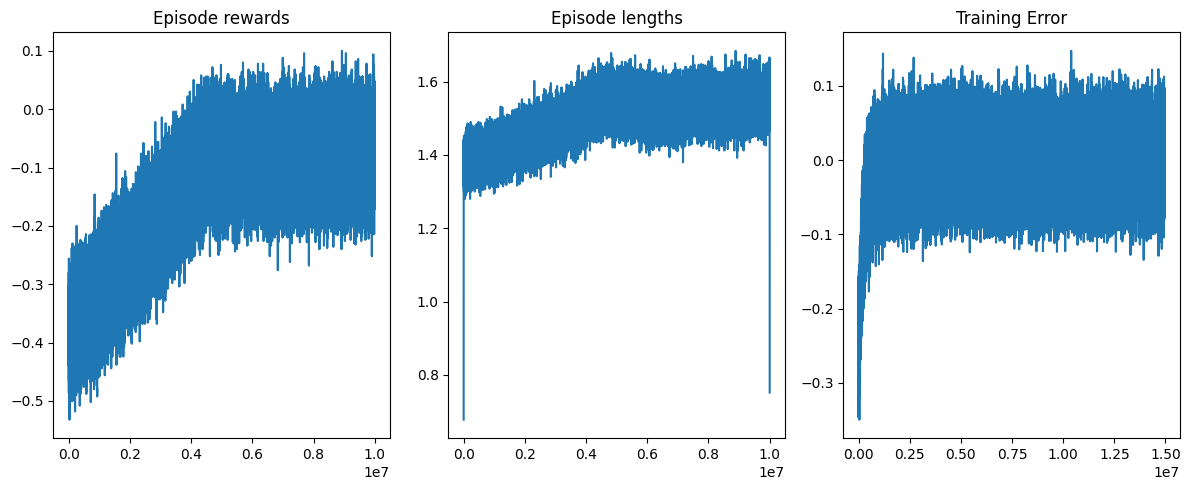

In [7]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

We can conclude the agent increased the accumulated reward per episode, and decreased the error, steadily. Then it started to stabilize (apparent as a *plateau* in the curves showing accumulated reward and training error). The agent should thus have acquired a relatively smart, and stable, behavior.

## Visualize the policy

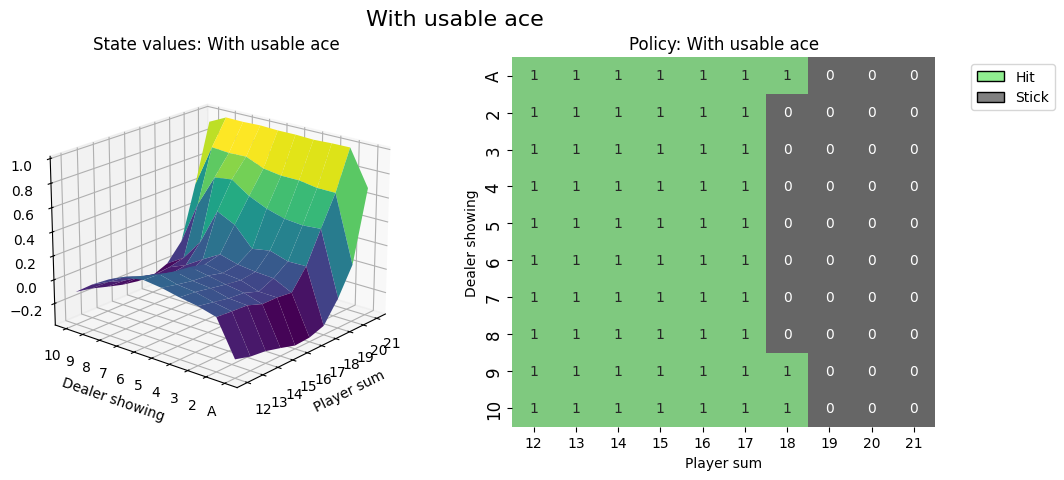

In [8]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # Convert the state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # Create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # Create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # Create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # Plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # Plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # Add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# State values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

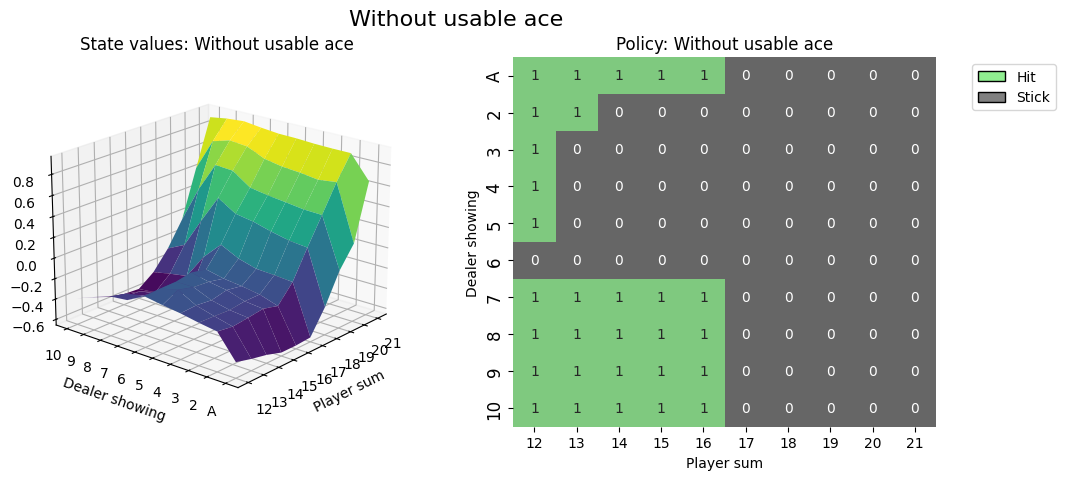

In [9]:
# State values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

It’s good practice to call env.close() at the end of your script, so that any used resources by the environment will be closed.

# 2.  Solve *Frozen Lake*  with Q-learning

In the Frozen Lake Gym environment introduced in the previous lab (lab 3), the agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile. See lab 3 or the following Gym documentation for more details: https://gym.openai.com/envs/FrozenLake-v0/

In contrast to last week (lab 3), today we will keep the original "*slippery*" feature on, so there will be very significant randomness to the direction followed (see doc for details: there is 66% chance of slipping through additional tiles at every step). Great news is the Q-learning algorithm is the same whether it learns strategies in stochastic or determinisitic environments: it is a model-free algorithm, so learns strategies for whatever environment it is interacting with...

## Imports

In [1]:
%matplotlib inline
from IPython.display import clear_output
import time  # Used to insert time breaks and slow down the game when vizualizing it
import gymnasium as gym
import numpy as np 
import matplotlib.pyplot as plt  


## [From last week] Execute random actions just to get familiar with the environment

In [2]:
# Load the FrozenLake Gym environment with graphical rendering to vizualize the environment
env = gym.make("FrozenLake-v1", render_mode="human")   
#env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

# Set to initial state
# env.reset()  

# # Loop over 50 steps
# for _ in range(5):
#     env.render()                                                 # Render on the screen
#     action = env.action_space.sample()                           # Choose a random action
#     new_state, reward, done, truncated, info = env.step(action)  # Carry out the action
    
#     if done:
#          env.reset()
            
# env.close()


## [New] Create a Q-learning table

The Q-learning lookup table is a mapping from all possible state-action pairs to the expected reward for taking an action at a particular state (*Q value* $Q(s_t,a_t)$), which the agent will keep updating during a reinforcement learning simulation.

The size of the Q-table will thus be $=$ number of states $\times$ number of actions.

For our simple discrete Frozen Lake problem, this means we have 4 actions for columns, and 16 possible states (player location on the 4 by 4 grid). So our table will look like:

<table style="width:100%">
  <tr>
      <th></th>
    <th>A0 - LEFT</th>
    <th>A1 - DOWN</th>
    <th>A2 - RIGHT</th>
    <th>A3 - UP</th>
  </tr>
  <tr>
    <td><strong>State 0</strong></td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
      <td>Q(s,a)</td>
      <td>Q(s,a)</td>
  </tr>
  <tr>
      <td><strong>State 1</strong></td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
      <td>Q(s,a)</td>
  </tr>
    <tr>
      <td><strong>State ...</strong></td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
        <td>...</td>
  </tr>
    <tr>
      <td><strong>State 15</strong></td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
        <td>Q(s,a)</td>
  </tr>
</table>

In [ ]:
# Let's create an environement without creating graphical rendering to increase speed
env = gym.make("FrozenLake-v1")
# Default equivalent to: env = gym.make("FrozenLake-v1", render_mode="rgb_array_list")
#env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

action_size = env.action_space.n
state_size = env.observation_space.n

# Start with very small values for all our Q(s,a)
q_table = np.zeros([state_size, action_size])
print("Q table dimensions: {} \n".format(q_table.shape))
q_table

## Set up Q-learning hyperparameters

The Q-learning update functions will require hyperparameters. We'll define them here. Often the best place to choose a good starting value for hyperparameters is by reading publications, or through experimentation. It's difficult to give general advice, as most environments are radically different to each other, and often hyperparameter tuning is required. 

In [4]:
# It is common to leave Hyperparameters in ALL CAPS to easily locate them
EPOCHS=20000  # Number of epochs/episodes to train for
ALPHA = 0.8   # Learning rate
GAMMA = 0.95  # Discount rate
# MAX_EPISODES = 100  # Optional, also defined in env setup above

# Exploration vs. Exploitation parameters
epsilon = 1.0        # Exploration rate
max_epsilon = 1.0    # Exploration probability at start
min_epsilon = 0.01   # Minimum exploration probability 
decay_rate = 0.001   # Exponential decay rate for exploration prob

## Implement Q-table update functions

First we will define some functions needed for training phase

1. `epsilon_greedy_action_selection`: Is used to implement the epsilon greedy action selection routine.
2. `compute_next_q_value`: Computes the next Q values according to the formula from the lecture
3. `reduce_epsilon`: Reduces the $\epsilon$ used for the epsilon greedy algorithm

### 1. Action selection function

If we simply always select the argmax() q-table value during training, we'll most likely get stuck in an exploitation loop. So we'll use a random value to randomly select an action from time to time, helping the model explore, rather than exploit. This is the idea of epsilon-greedy action selection.

In [5]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    '''
    Returns an action for the agent. Note how it uses a random number to decide on
    exploration versus explotation trade-off.
    '''
    random_number = np.random.random()
    
    # EXPLOITATION, USE BEST Q(s,a) Value
    if random_number > epsilon:
        # Action row for a particular state
        state_row = q_table[discrete_state,:]
        # Index of highest action for state
        # Recall action is mapped to index (e.g. 0=LEFT, 1=DOWN, etc..)
        action = np.argmax(state_row)
    
    # EXPLORATION, USE A RANDOM ACTION
    else:
        # Return a random 0,1,2,3 action
        action = env.action_space.sample()
        
    return action


### 2. Q-values update function

Here we have our main Q-Learning update equation, note how it takes in the old q-value, the next optimal q value, along with our current reward, and then updates the next q value accordingly.

In [6]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)


### 3. Epsilon schedule function

As training continues, we need to balance explotation versus exploration, we want ot make sure our agent doesn't get trapped in a cycle going from an F square to another F Square back and forth. We also don't want our agent permanently choosing random values. We'll use the function below to try to balance this.

In [7]:
def reduce_epsilon(epsilon,epoch):
    
    return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epoch)


## Train RL agent and update Q-table

If you plan on plotting your training progress, make sure to put this all in the same cell, otherwise matplotlib may not connect to the training loop and just show an empty plot.

In [8]:
# Reset just in case, watch lecture on this.
q_table = np.zeros([state_size, action_size])
total_reward = 0
epsilon = 1

In [9]:
# List of rewards
rewards = []

# Play 20k games (if EPOCHS was set to 20k)
for episode in range(EPOCHS):
    
    # Reset the environment
    state, info = env.reset() 
                              
    done = False
    total_rewards = 0
    
    while not done:
        action = epsilon_greedy_action_selection(epsilon, q_table, state)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, truncated, info = env.step(action)

        # Look up current/old qtable value Q(s_t,a_t)
        old_q_value =  q_table[state,action]  

        # Get the next optimal Q-Value
        next_optimal_q_value = np.max(q_table[new_state, :])  

        # Compute next q value
        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)   

        # Update Q Table
        q_table[state,action] = next_q

        # Track rewards
        total_rewards = total_rewards + reward
        
        # Our new state is state
        state = new_state
        
    episode += 1
    
    # Reduce epsilon (because we need less and less exploration)
    epsilon = reduce_epsilon(epsilon,episode) 
    rewards.append(total_rewards)


# env.close() # Comment to fix error "display Surface quit", this will let the env opened 

In [ ]:
plt.plot(range(EPOCHS),np.cumsum(rewards), '-', color = [0.3, 0, 0.6], linewidth=8)
plt.xlabel('Episode')
plt.ylabel('Learned Value')
plt.title('Evolution of values during training')


## [optional] Watch the agent learn during a training simulation

With the code below, you can "watch" the curve above evolve as training happens...

In [ ]:
# Reset just in case, watch lecture on this [Jeremy] Delete this, do we need it?

q_table = np.zeros([state_size, action_size])
total_reward = 0
epsilon = 1

from time import sleep
fig = plt.figure()
plt.ion()
ax = fig.add_subplot(111)

fig.canvas.draw()
log_interval = 1000 # Plot a new point every log_interval games, do NOT make this too small!
epoch_plot_tracker = []
total_reward_plot_tracker = []

for episode in range(EPOCHS):
    
    sleep(0.0002)
    
    # Reset the environment
    state, info = env.reset()
    done = False
    total_rewards = 0
    
    while not done:
        
        action = epsilon_greedy_action_selection(epsilon,q_table, state)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, truncated, info = env.step(action)
        
        # Look up current/old qtable value Q(s_t,a_t)
        old_q_value =  q_table[state,action]  

        # Get the next optimal Q-Value
        next_optimal_q_value = np.max(q_table[new_state, :])  

        # Compute next q value
        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)   

        # Update Q Table
        q_table[state,action] = next_q
        
        # Our new state is state
        state = new_state
        
          #### Use Ctrl+/ to uncomment this block all at once.
#         ########## OPTIONAL TABLE REPORTING AND DISPLAY #######################
#         print(f"Epsilon is currently {epsilon}")
#         print(f"Currently on Epoch {epoch}, total reward earned so far is {total_reward}")
#         print(f"Current state {state} and performing action {action}")
#         env.render()
#         print(q_table)
#         time.sleep(0.01)
#         clear_output(wait=True)
#         ######################################################################
        
    # episode += 1
    # Reduce epsilon (because we need less and less exploration)
    epsilon = reduce_epsilon(epsilon,episode) 
    
    total_reward += reward # Since +1 is only time reward is recorded, meaning game is also done
    total_reward_plot_tracker.append(total_reward)
    epoch_plot_tracker.append(episode)
    
    # Plot the points and running mean 
    if episode % log_interval == 0:
        ax.clear() 
        ax.plot(epoch_plot_tracker,total_reward_plot_tracker, '-', color = [0.3, 0, 0.6], linewidth=6) 
        ax.set_xlabel('Episode')
        ax.set_ylabel('Learned Value');
        ax.set_title('Evolution of values during training')
        fig.canvas.draw()
        plt.pause(0.1)

env.close()
plt.show(block=False)


## Exploit learned Q values in test simulations

Finally, let's showcase how the trained agent performs by graphically vizualizing it behaving in the environment. 

In [ ]:
# Create a new environment with graphical rendering 
# If you create your own FrozenLake env (see exercices below),
# make sure this env is identical as the one used for training

env = gym.make("FrozenLake-v1", render_mode="human")  

state, info = env.reset()
rewards = 0
for _ in range(100):
    
    env.render()
    
    action = np.argmax(q_table[state])                      # Chose action from the Q-Table
    state, reward, done, truncated, info = env.step(action) # Carry out the action

    #time.sleep(0.1)
    clear_output(wait=True)
    
    if done:
        print(f"Test episode done")
        state, info = env.reset()
        #break

env.close()

**Exercise 1**: Create a `FrozenLake` Gym env with a grid of 8x8 cells 

Solution is indicated in the doc at https://www.gymlibrary.dev/environments/toy_text/frozen_lake.




**Exercise 2**: Create a `FrozenLake` Gym env with a grid of 8x8 cells and your own custom locations for holes. 

Solution is also indicated in the doc at https://www.gymlibrary.dev/environments/toy_text/frozen_lake.

## Thank you everyone!